# Extract Liberty Mutual auto table 

Author: Mo Al Elew

In [1]:
import geopandas as gpd
import pandas as pd
import stringcase
import tabula

# Constants

In [2]:
RATE_TABLE_PDF_FP = "./inputs/mi-liberty-mutual-auto-pre-reform-territory-rates.pdf"
TERR_TABLE_PDF_FP = "./inputs/miaterrpgs-liberty-mutual-pre-reform-territoty-a.pdf"
DEMOGRAPHICS_FP = "../../01_demographics/outputs/zcta_2019_demographics_map.geojson"

UNPROCESSED_TERRITORY_TABLE_FP = "./outputs/rate_table.csv"
CLEAN_EXPORT_FP = "./outputs/libertymutual_clean_auto.csv"
CLEAN_GIS_EXPORT_FP = "./outputs/libertymutual_auto_clean_gis.geojson"
PROCESSED_EXPORT_FP = "./outputs/libertymutual_auto.csv"
GIS_EXPORT_FP = "./outputs/libertymutual_auto_gis.geojson"

COMPANY_NAME = "Liberty Mutual"
VEHICLE_TYPE = "Auto"
FACTOR_CIRCUMVENTED = "zip"
FACTOR_NAME = "Garaging Territory"
GEOGRAPHY_FACTOR = "Territory"
GEOGRAPHY_TYPE = "zip"

ROUNDING_PRECISION = 2
TERR_CODE_ZERO_FILL = 3

In [3]:
BASE_COLUMNS = [
    "company",
    "vehicle_type",
    "factor_circumvented",
    "factor_name",
    "geography_factor",
    "geography_type",
    "geography_factor_id",
    "latitude",
    "longitude",
    "county_fips",
    "tract_fips",
    "block_group_fips",
    "zip",
    "place_name_fips",
]

GIS_COLS = [
    "geo_id",
    "geo_name",
    "tot_pop",
    "white_tot",
    "black_tot",
    "white_pct",
    "black_pct",
    "median_income",
    "geometry",
]

CLEAN_COLS = [
    "geo_id",
    "geo_name",
    "tot_pop",
    "white_tot",
    "black_tot",
    "white_pct",
    "black_pct",
    "median_income",
    "generic_location_based_premium",
    "location_effect",
    "zip",
    "is_in_detroit",
    "geometry",
]

In [4]:
RATE_PREFIX = "rate_"


def get_rate_columns(df_rate_table):
    return [col for col in df_rate_table.columns if col.startswith(RATE_PREFIX)]


def get_avg_rate_factor(df_rate_table):
    rate_cols = get_rate_columns(df_rate_table)
    return df_rate_table[rate_cols].mean(axis=1)

# Read table

## Territory table

In [5]:
col2str = {"dtype": str}
kwargs = {"pandas_options": col2str}
TERRITORY_TABLES_LIST = tabula.read_pdf(
    TERR_TABLE_PDF_FP, pages="all", stream=True, **kwargs
)
DF_TERRITORY = pd.concat(TERRITORY_TABLES_LIST)
DF_TERRITORY.info()

Jul 12, 2024 6:53:20 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Jul 12, 2024 6:53:20 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Jul 12, 2024 6:53:20 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Jul 12, 2024 6:53:20 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Jul 12, 2024 6:53:20 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Jul 12, 2024 6:53:21 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>


<class 'pandas.core.frame.DataFrame'>
Index: 325 entries, 0 to 53
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ZIP     324 non-null    object
 1   TERR    324 non-null    object
 2   ZIP.1   309 non-null    object
 3   TERR.1  309 non-null    object
 4   ZIP.2   270 non-null    object
 5   TERR.2  270 non-null    object
 6   ZIP.3   271 non-null    object
 7   TERR.3  271 non-null    object
dtypes: object(8)
memory usage: 22.9+ KB


Jul 12, 2024 6:53:21 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>


In [6]:
df = DF_TERRITORY[["ZIP", "TERR"]].copy()

df1 = DF_TERRITORY[["ZIP.1", "TERR.1"]].copy()
df2 = DF_TERRITORY[["ZIP.2", "TERR.2"]].copy()
df3 = DF_TERRITORY[["ZIP.3", "TERR.3"]].copy()

df1.columns = df.columns
df2.columns = df.columns
df3.columns = df.columns

DF_TERRITORY = pd.concat([df, df1, df2, df3]).dropna(axis=0, how="all")
DF_TERRITORY["TERR"] = DF_TERRITORY["TERR"].str.zfill(TERR_CODE_ZERO_FILL)
DF_TERRITORY

,ZIP,TERR
0,48001,132
1,48002,133
2,48003,133
3,48004,133
4,48005,121
...,...,...
49,49826,027
50,49827,027
51,49829,025
52,49831,025


## Rate table 

In [7]:
col2str = {"dtype": str}
kwargs = {"pandas_options": col2str}
TERRITORY_RATE_TABLES_LIST = tabula.read_pdf(
    RATE_TABLE_PDF_FP, pages="all", lattice=True, **kwargs
)
DF_TERRITORY_RATES = pd.concat(TERRITORY_RATE_TABLES_LIST)
DF_TERRITORY_RATES.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 34
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Territory                     120 non-null    object
Liability             120 non-null    object
PIP                     120 non-null    object
PPI                120 non-null    object
Comprehensive  120 non-null    object
Collision     120 non-null    object
dtypes: object(6)
memory usage: 6.6+ KB


In [8]:
DF_TERRITORY_RATES

,Territory,"$50,000\rLiability",Basic\rPIP,"$1,000,000\rPPI",$50 Deductible\rComprehensive,$200 Deductible\rCollision
0,007,288,1142,81,581,2609
1,011,351,1576,101,727,2601
2,012,443,1835,115,1105,2701
3,020,368,1380,94,818,2673
4,025,381,1570,110,1912,2100
...,...,...,...,...,...,...
30,987,839,4490,200,4162,4823
31,988,318,1309,86,963,2189
32,991,788,4650,187,3785,5329
33,997,397,1465,101,948,3007


# Build processed table

In [9]:
df_processed_table = DF_TERRITORY_RATES.copy()

## Rename columns

In [10]:
def create_rate_label(col_name):
    RATE_PREFIX = "rate_"
    return RATE_PREFIX + stringcase.snakecase(col_name.lower()).replace("___", "_")


def rename_rate_columns(df):
    rate_col_names = df.columns[1:]
    extracted_rate_col_names = [
        create_rate_label(col_name) for col_name in rate_col_names
    ]
    rate_col_renames = dict(zip(rate_col_names, extracted_rate_col_names))
    return df.rename(columns=rate_col_renames)


df_processed_table = rename_rate_columns(df_processed_table)
rate_col_names = list(df_processed_table.columns[1:])
df_processed_table

,Territory,"rate_$50,000_liability",rate_basic_pip,"rate_$1,000,000_ppi",rate_$50_deductible_comprehensive,rate_$200_deductible_collision
0,007,288,1142,81,581,2609
1,011,351,1576,101,727,2601
2,012,443,1835,115,1105,2701
3,020,368,1380,94,818,2673
4,025,381,1570,110,1912,2100
...,...,...,...,...,...,...
30,987,839,4490,200,4162,4823
31,988,318,1309,86,963,2189
32,991,788,4650,187,3785,5329
33,997,397,1465,101,948,3007


## Calculate generic_location_based_premium and location_effect

In [11]:
rate_cols = df_processed_table.columns[1:]
df_processed_table[rate_cols] = df_processed_table[rate_cols].astype(int)
df_processed_table["generic_location_based_premium"] = df_processed_table[
    rate_cols
].sum(axis=1)

median_generic_location_based_premium = df_processed_table[
    "generic_location_based_premium"
].median()
df_processed_table["location_effect"] = round(
    df_processed_table["generic_location_based_premium"]
    / median_generic_location_based_premium,
    ROUNDING_PRECISION,
)

rate_col_names = rate_col_names + ["generic_location_based_premium", "location_effect"]

## Replace territory code with matching zip code

I am doing a 1:m merge for territory to zip. The territory code is basically a grouping variable for the base rate, so I want to expand the data to include a single row for each zip code.

In [12]:
assert (df_processed_table["Territory"].value_counts() == 1).all()
assert DF_TERRITORY["TERR"].nunique() < DF_TERRITORY["ZIP"].nunique()

df_processed_table = DF_TERRITORY.merge(
    df_processed_table, left_on="TERR", right_on="Territory", how="left", validate="m:1"
)
df_processed_table

,ZIP,TERR,Territory,"rate_$50,000_liability",rate_basic_pip,"rate_$1,000,000_ppi",rate_$50_deductible_comprehensive,rate_$200_deductible_collision,generic_location_based_premium,location_effect
0,48001,132,132,452,2330,106,712,2844,6444,1.00
1,48002,133,133,473,2082,120,1040,3095,6810,1.06
2,48003,133,133,473,2082,120,1040,3095,6810,1.06
3,48004,133,133,473,2082,120,1040,3095,6810,1.06
4,48005,121,121,465,2111,131,828,3421,6956,1.08
...,...,...,...,...,...,...,...,...,...,...
1169,49826,027,027,352,1350,102,1073,2290,5167,0.80
1170,49827,027,027,352,1350,102,1073,2290,5167,0.80
1171,49829,025,025,381,1570,110,1912,2100,6073,0.94
1172,49831,025,025,381,1570,110,1912,2100,6073,0.94


## Geography columns

Rename geography index column 

In [13]:
df_processed_table = df_processed_table.rename(columns={"ZIP": "geography_factor_id"})
df_processed_table

,geography_factor_id,TERR,Territory,"rate_$50,000_liability",rate_basic_pip,"rate_$1,000,000_ppi",rate_$50_deductible_comprehensive,rate_$200_deductible_collision,generic_location_based_premium,location_effect
0,48001,132,132,452,2330,106,712,2844,6444,1.00
1,48002,133,133,473,2082,120,1040,3095,6810,1.06
2,48003,133,133,473,2082,120,1040,3095,6810,1.06
3,48004,133,133,473,2082,120,1040,3095,6810,1.06
4,48005,121,121,465,2111,131,828,3421,6956,1.08
...,...,...,...,...,...,...,...,...,...,...
1169,49826,027,027,352,1350,102,1073,2290,5167,0.80
1170,49827,027,027,352,1350,102,1073,2290,5167,0.80
1171,49829,025,025,381,1570,110,1912,2100,6073,0.94
1172,49831,025,025,381,1570,110,1912,2100,6073,0.94


In [14]:
df_processed_table["zip"] = df_processed_table["geography_factor_id"]

## Fill constants

In [15]:
df_processed_table["company"] = COMPANY_NAME
df_processed_table["vehicle_type"] = VEHICLE_TYPE
df_processed_table["factor_circumvented"] = FACTOR_CIRCUMVENTED
df_processed_table["factor_name"] = FACTOR_NAME
df_processed_table["geography_factor"] = GEOGRAPHY_FACTOR
df_processed_table["geography_type"] = GEOGRAPHY_TYPE

In [16]:
def fill_null_columns(df, base_columns):
    base_col_to_fill = list(set(base_columns) - set(df.columns))
    df[base_col_to_fill] = None
    return df


df_processed_table = fill_null_columns(df_processed_table, BASE_COLUMNS)
df_processed_table

,geography_factor_id,TERR,Territory,"rate_$50,000_liability",rate_basic_pip,"rate_$1,000,000_ppi",rate_$50_deductible_comprehensive,rate_$200_deductible_collision,generic_location_based_premium,location_effect,...,factor_circumvented,factor_name,geography_factor,geography_type,longitude,latitude,place_name_fips,tract_fips,block_group_fips,county_fips
0,48001,132,132,452,2330,106,712,2844,6444,1.00,...,zip,Garaging Territory,Territory,zip,None,None,None,None,None,None
1,48002,133,133,473,2082,120,1040,3095,6810,1.06,...,zip,Garaging Territory,Territory,zip,None,None,None,None,None,None
2,48003,133,133,473,2082,120,1040,3095,6810,1.06,...,zip,Garaging Territory,Territory,zip,None,None,None,None,None,None
3,48004,133,133,473,2082,120,1040,3095,6810,1.06,...,zip,Garaging Territory,Territory,zip,None,None,None,None,None,None
4,48005,121,121,465,2111,131,828,3421,6956,1.08,...,zip,Garaging Territory,Territory,zip,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,49826,027,027,352,1350,102,1073,2290,5167,0.80,...,zip,Garaging Territory,Territory,zip,None,None,None,None,None,None
1170,49827,027,027,352,1350,102,1073,2290,5167,0.80,...,zip,Garaging Territory,Territory,zip,None,None,None,None,None,None
1171,49829,025,025,381,1570,110,1912,2100,6073,0.94,...,zip,Garaging Territory,Territory,zip,None,None,None,None,None,None
1172,49831,025,025,381,1570,110,1912,2100,6073,0.94,...,zip,Garaging Territory,Territory,zip,None,None,None,None,None,None


# Demographic and GIS data

## Read data

In [17]:
GDF_ZIP = gpd.read_file(DEMOGRAPHICS_FP)
gdf_zip = GDF_ZIP.copy()
gdf_zip = gdf_zip[GIS_COLS].copy()
gdf_zip.head()

,geo_id,geo_name,tot_pop,white_tot,black_tot,white_pct,black_pct,median_income,geometry
0,48755,ZCTA5 48755,2993,2787,32,93.1,1.1,52321,"POLYGON ((-83.41544 43.92114, -83.39695 43.925..."
1,48756,ZCTA5 48756,4630,4369,3,94.4,0.1,32685,"POLYGON ((-84.07325 44.20470, -84.07271 44.205..."
2,48757,ZCTA5 48757,3742,3505,22,93.7,0.6,63813,"POLYGON ((-83.77807 43.47867, -83.76873 43.478..."
3,48759,ZCTA5 48759,3211,3135,34,97.6,1.1,50857,"MULTIPOLYGON (((-83.29783 43.77178, -83.29595 ..."
4,48760,ZCTA5 48760,1419,1293,82,91.1,5.8,50451,"POLYGON ((-83.30851 43.27020, -83.30782 43.270..."


## Merge

In [18]:
gdf_processed_table = gdf_zip.merge(
    df_processed_table,
    right_on="zip",
    left_on="geo_id",
    how="right",
    validate="1:1",
)

In [19]:
# gdf_processed_table = gdf.merge(
#     df_processed_table,
#     right_on="zip",
#     left_on="ZCTA5CE00",
#     how="right",
#     validate="1:1",
# )
# gdf_processed_table.to_file("./test.geojson", driver="GeoJSON")

<Axes: >

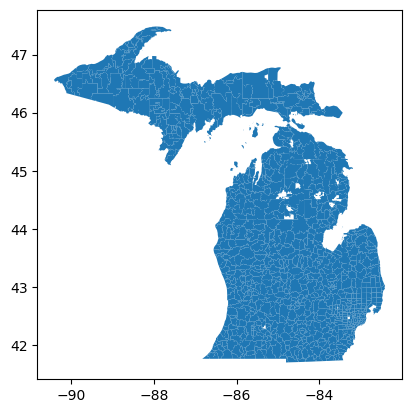

In [20]:
gdf_processed_table.plot()

## Update data types

In [21]:
gdf_processed_table = gdf_processed_table.replace("-", 0)
gdf_processed_table["median_income"] = gdf_processed_table["median_income"].replace(
    "2,500-", "2500"
)
gdf_processed_table["median_income"] = gdf_processed_table["median_income"].astype(
    float
)

## Detroit filter

In [22]:
MUNICIPAL_BOUND_GIS_FP = "../../02_allstate/inputs/Municipal_Boundaries.zip"
MUNICIPALITIES_TO_EXTRACT = ["Detroit"]
GDF_MUNICIPAL = gpd.read_file(MUNICIPAL_BOUND_GIS_FP)
gdf_detroit = GDF_MUNICIPAL[GDF_MUNICIPAL["NAME"].isin(MUNICIPALITIES_TO_EXTRACT)]

In [23]:
gdf_detroit_points = list(
    gpd.overlay(gdf_processed_table, gdf_detroit.to_crs("EPSG:4269"))[
        "geography_factor_id"
    ]
)
gdf_processed_table["is_in_detroit"] = gdf_processed_table["geography_factor_id"].isin(
    gdf_detroit_points
)

<Axes: >

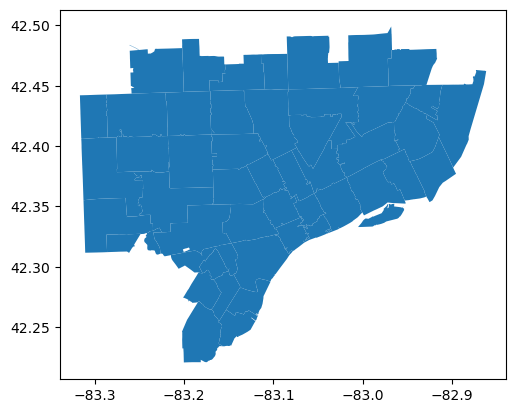

In [24]:
gdf_processed_table[gdf_processed_table["is_in_detroit"]].plot()

# Export

In [25]:
expected_col_order = BASE_COLUMNS + rate_col_names
df_export = df_processed_table[expected_col_order]
df_export.to_csv(PROCESSED_EXPORT_FP, index=False)
df_export

,company,vehicle_type,factor_circumvented,factor_name,geography_factor,geography_type,geography_factor_id,latitude,longitude,county_fips,...,block_group_fips,zip,place_name_fips,"rate_$50,000_liability",rate_basic_pip,"rate_$1,000,000_ppi",rate_$50_deductible_comprehensive,rate_$200_deductible_collision,generic_location_based_premium,location_effect
0,Liberty Mutual,Auto,zip,Garaging Territory,Territory,zip,48001,None,None,None,...,None,48001,None,452,2330,106,712,2844,6444,1.00
1,Liberty Mutual,Auto,zip,Garaging Territory,Territory,zip,48002,None,None,None,...,None,48002,None,473,2082,120,1040,3095,6810,1.06
2,Liberty Mutual,Auto,zip,Garaging Territory,Territory,zip,48003,None,None,None,...,None,48003,None,473,2082,120,1040,3095,6810,1.06
3,Liberty Mutual,Auto,zip,Garaging Territory,Territory,zip,48004,None,None,None,...,None,48004,None,473,2082,120,1040,3095,6810,1.06
4,Liberty Mutual,Auto,zip,Garaging Territory,Territory,zip,48005,None,None,None,...,None,48005,None,465,2111,131,828,3421,6956,1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,Liberty Mutual,Auto,zip,Garaging Territory,Territory,zip,49826,None,None,None,...,None,49826,None,352,1350,102,1073,2290,5167,0.80
1170,Liberty Mutual,Auto,zip,Garaging Territory,Territory,zip,49827,None,None,None,...,None,49827,None,352,1350,102,1073,2290,5167,0.80
1171,Liberty Mutual,Auto,zip,Garaging Territory,Territory,zip,49829,None,None,None,...,None,49829,None,381,1570,110,1912,2100,6073,0.94
1172,Liberty Mutual,Auto,zip,Garaging Territory,Territory,zip,49831,None,None,None,...,None,49831,None,381,1570,110,1912,2100,6073,0.94


In [26]:
DF_TERRITORY_RATES.to_csv(UNPROCESSED_TERRITORY_TABLE_FP, index=False)

In [27]:
gdf_processed_table[CLEAN_COLS].to_csv(CLEAN_EXPORT_FP, index=False)
gdf_processed_table[CLEAN_COLS].to_file(CLEAN_GIS_EXPORT_FP, driver="GeoJSON")
gdf_processed_table.to_file(GIS_EXPORT_FP, driver="GeoJSON")

# Appendix
